In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN_class
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.preprocessing import StandardScaler as Standardize
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor as KNN_reg
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
import time
from sklearn.metrics import roc_curve, auc
from datetime import datetime
%matplotlib inline

In [3]:
#Read in data
df=pd.read_csv('loan_data.csv')
df.head()
print df.shape

/Users/ChristyL/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(887379, 74)


Before we ran any model-building, we wanted to remove a test set that we would store away for the final model accuracy testing. To mimic the circumstances under which Lending Club would be using the model, we decided to remove the 30% most recent loans.

In [4]:
#Creating testing set by 30% of most recent loans
df['loan_date'] =pd.to_datetime(df.issue_d, format='%b-%y')
#df.head()


In [5]:
df=df.sort(columns='loan_date', ascending=False)
n=int(df.shape[0]*.3)
df_test=df.iloc[:n]
df_train=df.iloc[n:]

#df_test.to_csv("loan_test.csv",index=False)


/Users/ChristyL/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [6]:
print df_train.shape
print df_test.shape

(621166, 75)
(266213, 75)


In [68]:
df_sample=df_train.sample(frac=.001)
df_sample.shape

(621, 75)

We first examine the distribution of our outcome variable, loan status.

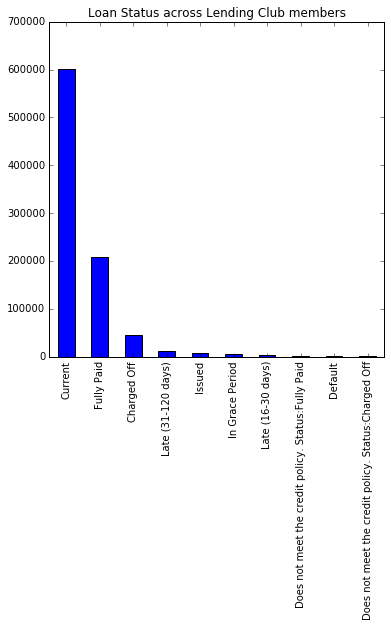

In [15]:
#Plotdistribution of loan status
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax=df['loan_status'].value_counts().plot(kind='bar')
ax.set_title("Loan Status across Lending Club members")
plt.show()

As observed above, there is a small fraction of defaulters, late, and charged off as compared to fully paid. Consequently, we decided to recode all observations that did not fully pay back their loans as defaulters and turn our problem into a binary classification. We also dropped all Current loans as their final loan status has not been determined yet.

Included in the dataset is the variable 'grade,'  which is an indicator Lending Club assigns each borrower to signal their level of risk to potential lenders. Lending Club does not release the algorithm they use to determine these grades, but our assumption is that it includes a majority of the variables in the dataset (else why would they collect them given the costs involved). Given that the grade variable encapsulates the other proxies for borrower risk that Lending Club makes use of, we were interested to see how well grade along predicts borrower default as our goal is to provide Lending Club with a new algorithm for a borrower risk grade that uses less discriminatory information and less information overall. <br/> <br/>
We begin first by seeing how well grade predicts borrower default on a random subset of test data.

In [9]:
#Create dataframe including only grade and loan status
df_grade=df_train[['grade','loan_status']]
df_grade = df_grade.drop(df_grade[df_grade.loan_status == "Current"].index)
df_grade.loc[df_grade['loan_status']!='Fully Paid', 'loan_status']='Default'
df_grade.head()

,grade,loan_status
715706,F,Fully Paid
715704,C,Fully Paid
715731,C,Default
715641,B,Default
721476,B,Fully Paid


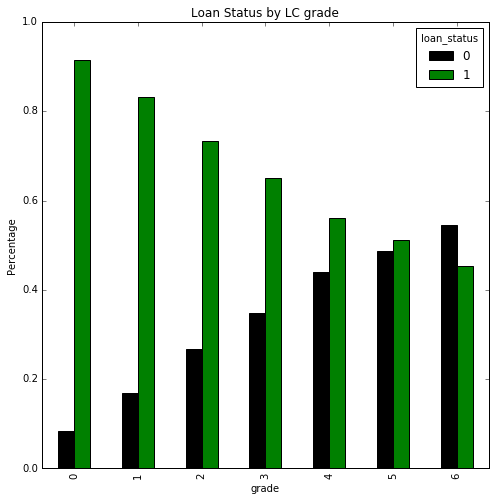

In [14]:
#Looking at distribution of loan status across LC's grade
var = df_grade.groupby(['grade','loan_status']).size()
pct= var / var.groupby(level=0).sum()
ax = pct.unstack().plot(kind='bar', figsize=(8,8),title="Loan Status by LC grade", color=['black','green'], grid=False)
ax.set_ylabel("Percentage")

In [10]:
#Processing data

#Encode categorical variables
def encode_categorical(array):
    if not array.dtype == np.dtype('float64'):
        return preprocessing.LabelEncoder().fit_transform(array) 
    else:
        return array
    
# Categorical columns for use in one-hot encoder
categorical = (df_grade.dtypes.values != np.dtype('float64'))

# Encode all labels
df_grade = df_grade.apply(encode_categorical)

# Categorical columns for use in one-hot encoder
categorical = (df_grade.dtypes.values != np.dtype('float64'))

# Get numpy array from data
x_grade = df_grade.values[:, :-1]
y_grade = df_grade.values[:, -1]


# Apply one hot endcoing
encoder = preprocessing.OneHotEncoder(categorical_features=categorical[:-1], sparse=False)  # Last value in mask is y
x_grade = encoder.fit_transform(x_grade)
x_grade.shape

#Splitting data into train & test
x_train_g, x_test_g, y_train_g, y_test_g = train_test_split(x_grade, y_grade, test_size=0.3, random_state=42)

print x_train_g.shape
print y_train_g.shape
print x_test_g.shape
print y_test_g.shape

(185549, 7)
(185549,)
(79521, 7)
(79521,)


In [12]:
#Predicting outcome with grade
score = lambda model, x_test_g, y_test_g: pd.Series([model.score(x_test_g, y_test_g), 
                                                 model.score(x_test_g[y_test_g==0], y_test_g[y_test_g==0]),
                                                 model.score(x_test_g[y_test_g==1], y_test_g[y_test_g==1])], 
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])


#KNN
knn = KNN_class(n_neighbors=5)
start = time.time()
knn.fit(x_train_g, y_train_g)
knn_time = time.time() - start
knn_scores = score(knn, x_test_g, y_test_g)
print "time to fit KNN: " +str(knn_time)

#Unweighted logistic regression
unweighted_logistic = LogisticRegression()
start = time.time()
unweighted_logistic.fit(x_train_g, y_train_g)
logit_time = time.time() - start
unweighted_log_scores = score(unweighted_logistic, x_test_g, y_test_g)
print "time to fit Unweighted Logit: " +str(logit_time)

#Unweighted logistic quadratic regression
unweighted_logistic_poly = LogisticRegression()

#Expand our predictor array with quadratic terms
start = time.time()
quad_features = preprocessing.PolynomialFeatures(degree = 2)
x_expanded_train_g = quad_features.fit_transform(x_train_g)
x_expanded_test_g = quad_features.fit_transform(x_test_g)

unweighted_logistic_poly.fit(x_expanded_train_g, y_train_g)
qlogit_time = time.time() - start
unweighted_log_poly_scores = score(unweighted_logistic_poly, x_expanded_test_g, y_test_g)
print "time to fit Unweighted Quadratic Logit: " +str(qlogit_time)



#Weighted logistic regression
weighted_logistic = LogisticRegression(class_weight='balanced')
start = time.time()
weighted_logistic.fit(x_train_g, y_train_g)
wlogit_time = time.time() - start
weighted_log_scores = score(weighted_logistic, x_test_g, y_test_g)
print "time to fit Weighted Logit: " +str(wlogit_time)


#Weighted quad logistic regression
weighted_logistic_poly = LogisticRegression(class_weight='balanced')
start = time.time()
#Expand our predictor array with quadratic terms
quad_features = preprocessing.PolynomialFeatures(degree = 2)
x_expanded_train_g = quad_features.fit_transform(x_train_g)
x_expanded_test_g = quad_features.fit_transform(x_test_g)

weighted_logistic_poly.fit(x_expanded_train_g, y_train_g)
qwlogit_time = time.time() - start
print "time to fit Weighted Quadratic Logit: " +str(qwlogit_time)
weighted_log_poly_scores = score(weighted_logistic_poly, x_expanded_test_g, y_test_g)


#LDA
lda = LDA()
start = time.time()
lda.fit(x_train_g, y_train_g)
lda_time = time.time() - start
lda_scores = score(lda, x_test_g, y_test_g)
print "time to fit LDA: " +str(lda_time)



#QDA
qda = QDA()
start = time.time()
qda.fit(x_train_g, y_train_g)
qda_time = time.time() - start
qda_scores = score(qda, x_test_g, y_test_g)
print "time to fit QDA: " +str(qda_time)



#Decision Tree
tree = DecisionTree(max_depth=3)
start = time.time()
tree.fit(x_train_g, y_train_g)
dt_time = time.time() - start
print "time to fit Decision Tree: " +str(dt_time)
tree_scores = score(tree, x_test_g, y_test_g)



#Random Forest
rf = RandomForest()
start = time.time()
rf.fit(x_train_g, y_train_g)
rf_time = time.time() - start
print "time to fit Random Forest: " +str(rf_time)
rf_scores = score(rf, x_test_g, y_test_g)



#Score Dataframe
score_df = pd.DataFrame({'knn': knn_scores, 
                         'unweighted logistic': unweighted_log_scores,
                         'unweighted quad logistic': unweighted_log_poly_scores,
                         'weighted logistic': weighted_log_scores,
                         'weighted quad logistic': weighted_log_poly_scores,
                         'lda': lda_scores,
                         'qda': qda_scores,
                         'tree': tree_scores,
                         'rf': rf_scores})
score_df

time to fit KNN: 92.3778989315
time to fit Unweighted Logit: 0.749459028244
time to fit Unweighted Quadratic Logit: 0.724826812744
time to fit Weighted Logit: 0.344781160355
time to fit Weighted Quadratic Logit: 0.719707965851


/Users/ChristyL/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/ChristyL/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


time to fit LDA: 1.23020982742
time to fit QDA: 0.138725996017
time to fit Decision Tree: 0.276183128357
time to fit Random Forest: 0.726907014847


,knn,lda,qda,rf,tree,unweighted logistic,unweighted quad logistic,weighted logistic,weighted quad logistic
overall accuracy,0.754442,0.754442,0.744935,0.755561,0.75443,0.755561,0.755561,0.573899,0.573899
accuracy on class 0,0.082804,0.082804,0.230490,0.019562,0.00000,0.019562,0.019562,0.742780,0.742780
accuracy on class 1,0.973064,0.973064,0.912390,0.995133,1.00000,0.995133,0.995133,0.518927,0.518927


Since we know that loan status prediction models tend to perform poorly on out of sample predictions in the future, we assess how well loan grade performs on our test set of the most recent loans.

In [13]:
#Assessing loan grade performance on recent loans using best model, weighted logistic

#Read in test data
loan_test=pd.read_csv('loan_test.csv')

df_grade_test=loan_test[['grade','loan_status']]
df_grade_test = df_grade_test.drop(df_grade_test[df_grade_test.loan_status == "Current"].index)
df_grade_test.loc[df_grade_test['loan_status']!='Fully Paid', 'loan_status']='Default'

# Categorical columns for use in one-hot encoder
categorical = (df_grade_test.dtypes.values != np.dtype('float64'))

# Encode all labels
df_grade_test = df_grade_test.apply(encode_categorical)

# Categorical columns for use in one-hot encoder
categorical = (df_grade_test.dtypes.values != np.dtype('float64'))

# Get numpy array from data
x = df_grade_test.values[:, :-1]
y = df_grade_test.values[:, -1]


# Apply one hot endcoing
encoder = preprocessing.OneHotEncoder(categorical_features=categorical[:-1], sparse=False)  # Last value in mask is y
x = encoder.fit_transform(x)


print 'total accuracy:', weighted_logistic.score(x,y)
print 'accuracy on defaulters:', weighted_logistic.score(x[y==0], y[y==0])
print 'accuracy on fully paid:', weighted_logistic.score(x[y==1], y[y==1])

total accuracy: 0.520896249391
accuracy on defaulters: 0.618480233567
accuracy on fully paid: 0.363497518137


Next, we created a function to manage the cleaning of the data. This is to ensure that all steps taken on the training data would be identical for the test data. The cleaning steps are commented out below but include encoding string variables, dropping variables that have more than 70% of their values missing, removing variables that Lending Club creates after they grade the individual, impute missing values using KNN, and creating new variables such as log of income, credit age, and revolving balance to income ratio. We also drop all Current loans and recode all people that defaulted, were late, charged off, etc. as default.

We then one-hot encode categorical variables and then randomly split into training and test datasets.

In [28]:
def clean_data(df):
    
    

    ###### Setting up internal functions
    def encode_categorical(array):
        if not array.dtype == np.dtype('float64'):
            return preprocessing.LabelEncoder().fit_transform(array) 
        else:
            return array
    
    
    def diff_month(d1, d2):
        return (d1.year - d2.year)*12 + d1.month - d2.month


    #Drop all current loans
    df = df.drop(df[df.loan_status == "Current"].index)
    n=df.shape[0]
    
    
    #Recode all late/charged off/etc. to default
    df.loc[df['loan_status']!='Fully Paid', 'loan_status']='Default'

    
    #Dropping columns that have more than 70% missing data
    miss=int(n*.5)
    
    df=df.dropna(axis=1,thresh=miss)
    
    #Recoding employee string values to integer
    df['emp_length_num'] = pd.Categorical.from_array(df.emp_length).codes
    df.loc[df['emp_length_num']==10, 'emp_length_num']=.5
    df.loc[df['emp_length_num']==1, 'emp_length_num']=10
    df.loc[df['emp_length_num']==0, 'emp_length_num']=1
    df.loc[df['emp_length_num']==.5, 'emp_length_num']=0
    df.loc[df['emp_length_num']==11, 'emp_length_num']=np.nan
    
    
    #Create credit age variable
    today=datetime.today()
    df['earliest_cr_line'] =pd.to_datetime(df.earliest_cr_line, format='%b-%y')
    df['credit_age'] = df.apply(lambda x: diff_month(today, x['earliest_cr_line']), axis=1)
    
    #Dropping variables not needed#
    #Dropping variables not being used in prediction --> string or discriminatory
    df.drop(['id','member_id','grade','sub_grade','addr_state','zip_code','emp_title','url','title','initial_list_status','emp_length','policy_code'], axis=1, inplace=True)

    #Dropping variables not being used in prediction --> dates (will use at a later stage)
    df.drop(['last_pymnt_d','last_credit_pull_d','issue_d','earliest_cr_line','loan_date'], axis=1, inplace=True)
    
    #Drop variables that LC uses post loan status prediction
    df.drop(['funded_amnt','funded_amnt_inv','term','int_rate','installment','pymnt_plan','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_amnt'],axis=1, inplace=True)

    # Categorical columns for use in one-hot encoder
    categorical = (df.dtypes.values != np.dtype('float64'))

    # Encode all labels
    df = df.apply(encode_categorical)
    
    #Get numeric data for predicting KNN values
    df_fill=df.dropna(axis=1,how='any')
    df_fillnum=df_fill._get_numeric_data()


    
    #Standardize values & apply KNN
    df_complete=df.copy()
    for c in df_complete.columns:
        #df_complete[c] = (df.c - df.c.mean())/df_complete.c.std(ddof=0)
        if df_complete[c].count()<n:
            df_filled = df_complete[~df_complete[c].isnull()]
            df_missing=df_complete[df_complete[c].isnull()]
            df_predict=df_missing.copy()


            x_fill=df_filled[df_fillnum.columns]
            x_fill_std = Standardize(with_mean=False).fit_transform(x_fill)
            x_miss=df_missing[df_fillnum.columns]
            x_miss_std = Standardize(with_mean=False).fit_transform(x_miss)
            y_fill=df_filled[c]


            knn_class = KNN_class(n_neighbors=5)
            knn_reg = KNN_reg(n_neighbors=5)
            if df_complete[c].dtype == np.dtype('float64'):
                knn_reg.fit(x_fill_std, y_fill)
                #ypred=knn_reg.predict(x_miss_std)
                df_predict.loc[:, c] = knn_reg.predict(x_miss_std)
                
            else:
                knn_class.fit(x_fill, y_fill)
                #ypred=knn_reg.predict(x_miss_std)
                df_predict.loc[:, c] = knn_class.predict(x_miss)
            
            df_complete = pd.concat([df_filled, df_predict])
            print str(c) + ' done'
    
    
    #Converting real valued predictors to float
    to_float = ['loan_amnt','revol_bal','acc_now_delinq']

    # Converted columns to floating point
    for feature_name in to_float:
        df_complete[feature_name] = df_complete[feature_name].astype(float)
    
    
    #Create new variables#
    #Log of income
    df_complete['log_annual_inc'] = df_complete['annual_inc'].apply(np.log, 1)

    #Right censor delinq
    df_complete.loc[df_complete['delinq_2yrs']>2, 'delinq_2yrs']=2
    df_complete.loc[df_complete['delinq_2yrs']<.5, 'delinq_2yrs']=0
    df_complete.loc[(df_complete['delinq_2yrs']>.5) & (df_complete['delinq_2yrs']<2), 'delinq_2yrs']=1

    df_complete['revol_inc_ratio']=df_complete['revol_bal']/df_complete['annual_inc']
    
    df_complete.drop(['annual_inc'],axis=1, inplace=True)
    
    
    #Order loan status at the end of dataset
    cols = list(df_complete.columns.values)
    cols.pop(cols.index('loan_status'))
    df_complete = df_complete[cols+['loan_status']]
    
    df_clean=df_complete
    
    #print 'shape of df:', df_clean.shape[0]
    return df_clean


In [77]:
df_train_clean=clean_data(df_train)
#Export cleaned training data
df_train_clean.to_csv("loan_train_clean.csv",index=False)

(265070, 55)
(265070, 22)
annual_inc done
delinq_2yrs done
inq_last_6mths done
open_acc done
pub_rec done
revol_util done
total_acc done
collections_12_mths_ex_med done
acc_now_delinq done
tot_coll_amt done
tot_cur_bal done
total_rev_hi_lim done
emp_length_num done
credit_age done


In [31]:
#Function to check percent of missing values in each variable
def getPctMissing(series):
    num = series.isnull().sum()
    den=series.shape[0]
    #den = series.count()
    return 100*(num/den)



In [17]:
#Reading in clean data
train_clean=pd.read_csv('loan_train_clean.csv')
train_clean.head()

,loan_amnt,home_ownership,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,emp_length_num,credit_age,log_annual_inc,revol_inc_ratio,loan_status
0,481.0,5,1,2,19.22,0.0,1.0,9.0,0.0,10393.0,...,0,0.0,0.0,26163.0,13100.0,6.0,259.0,11.002100,0.173217,1
1,291.0,1,1,2,10.78,0.0,3.0,9.0,1.0,12974.0,...,0,0.0,74.0,140467.0,17800.0,10.0,343.0,11.482466,0.133753,1
2,771.0,1,1,2,27.22,2.0,0.0,10.0,0.0,3434.0,...,0,0.0,0.0,145013.0,3500.0,10.0,277.0,10.933107,0.061321,0
3,171.0,4,1,2,4.23,1.0,0.0,9.0,1.0,715.0,...,0,0.0,0.0,8066.0,3200.0,10.0,107.0,10.596635,0.017875,0
4,670.0,1,0,2,14.76,0.0,0.0,7.0,0.0,8957.0,...,0,0.0,0.0,155046.0,13800.0,3.0,58.0,10.878047,0.169000,0


In [81]:
train_clean['loan_status'].value_counts()

1    199866
0     65204
Name: loan_status, dtype: int64

In [18]:
#Take sample so model runs faster
train_sample=train_clean.sample(frac=.50)
train_sample.shape

(132535, 23)

In [20]:
#One hot encoding
def one_hot(df):
    # Categorical columns for use in one-hot encoder
    categorical = (df.dtypes.values != np.dtype('float64'))
    print categorical

    # Get numpy array from data
    x = df.values[:, :-1]
    y = df.values[:, -1]
    
    # Apply one hot endcoing
    encoder = preprocessing.OneHotEncoder(categorical_features=categorical[:-1], sparse=False)  # Last value in mask is y
    x = encoder.fit_transform(x)
    
    print 'x shape', x.shape
    print 'y shape', y.shape
    return x, y



In [34]:
(x,y)=one_hot(train_sample)

[False  True  True  True False False False False False False False False
 False  True False False False False False False False False  True]
x shape (132535, 41)
y shape (132535,)


In [22]:
#Splitting data into train & test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

print x_train.shape
print y_train.shape
print x_test.shape
print y_test.shape

(92774, 41)
(92774,)
(39761, 41)
(39761,)


For our baseline models, we train a series of models on the cleaned data and assess the performance. We examine overall accuracy as well as accuracy on defaulters and accuracy on fully paid.

In [90]:
# Running initial models
score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==0], y_test[y_test==0]),
                                                 model.score(x_test[y_test==1], y_test[y_test==1])], 
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])


#KNN
knn = KNN_class(n_neighbors=5)
start = time.time()
knn.fit(x_train, y_train)
knn_time = time.time() - start
knn_scores = score(knn, x_test, y_test)
print "time to fit KNN: " +str(knn_time)

#Unweighted logistic regression
unweighted_logistic = LogisticRegression()
start = time.time()
unweighted_logistic.fit(x_train, y_train)
logit_time = time.time() - start
unweighted_log_scores = score(unweighted_logistic, x_test, y_test)
print "time to fit Unweighted Logit: " +str(logit_time)

#Unweighted logistic quadratic regression
unweighted_logistic_poly = LogisticRegression()

#Expand our predictor array with quadratic terms
start = time.time()
quad_features = preprocessing.PolynomialFeatures(degree = 2)
x_expanded_train = quad_features.fit_transform(x_train)
x_expanded_test = quad_features.fit_transform(x_test)

unweighted_logistic_poly.fit(x_expanded_train, y_train)
qlogit_time = time.time() - start
unweighted_log_poly_scores = score(unweighted_logistic_poly, x_expanded_test, y_test)
print "time to fit Unweighted Quadratic Logit: " +str(qlogit_time)



#Weighted logistic regression
weighted_logistic = LogisticRegression(class_weight='balanced')
start = time.time()
weighted_logistic.fit(x_train, y_train)
wlogit_time = time.time() - start
weighted_log_scores = score(weighted_logistic, x_test, y_test)
print "time to fit Weighted Logit: " +str(wlogit_time)


#Weighted quad logistic regression
weighted_logistic_poly = LogisticRegression(class_weight='balanced')
start = time.time()
#Expand our predictor array with quadratic terms
quad_features = preprocessing.PolynomialFeatures(degree = 2)
x_expanded_train = quad_features.fit_transform(x_train)
x_expanded_test = quad_features.fit_transform(x_test)

weighted_logistic_poly.fit(x_expanded_train, y_train)
qwlogit_time = time.time() - start
print "time to fit Weighted Quadratic Logit: " +str(qwlogit_time)
weighted_log_poly_scores = score(weighted_logistic_poly, x_expanded_test, y_test)


#LDA
lda = LDA()
start = time.time()
lda.fit(x_train, y_train)
lda_time = time.time() - start
lda_scores = score(lda, x_test, y_test)
print "time to fit LDA: " +str(lda_time)



#QDA
qda = QDA()
start = time.time()
qda.fit(x_train, y_train)
qda_time = time.time() - start
qda_scores = score(qda, x_test, y_test)
print "time to fit QDA: " +str(qda_time)



#Decision Tree
tree = DecisionTree(max_depth=3)
start = time.time()
tree.fit(x_train, y_train)
dt_time = time.time() - start
print "time to fit Decision Tree: " +str(dt_time)
tree_scores = score(tree, x_test, y_test)



#Random Forest
rf = RandomForest(class_weight='balanced')
start = time.time()
rf.fit(x_train, y_train)
rf_time = time.time() - start
print "time to fit Random Forest: " +str(rf_time)
rf_scores = score(rf, x_test, y_test)


#Balanced Random Forest
brf = RandomForest()
start = time.time()
brf.fit(x_train, y_train)
brf_time = time.time() - start
print "time to fit Random Forest: " +str(brf_time)
brf_scores = score(brf, x_test, y_test)



#Score Dataframe
score_df = pd.DataFrame({'knn': knn_scores, 
                         'unweighted logistic': unweighted_log_scores,
                         'unweighted quad logistic': unweighted_log_poly_scores,
                         'weighted logistic': weighted_log_scores,
                         'weighted quad logistic': weighted_log_poly_scores,
                         'lda': lda_scores,
                         'qda': qda_scores,
                         'tree': tree_scores,
                         'rf': rf_scores,
                         'brf': brf_scores})
score_df

time to fit KNN: 95.6256661415
time to fit Unweighted Logit: 2.45746397972
time to fit Unweighted Quadratic Logit: 94.4321699142
time to fit Weighted Logit: 12.1821789742
time to fit Weighted Quadratic Logit: 117.933777094
time to fit LDA: 2.01203989983
time to fit QDA: 0.878043174744
time to fit Decision Tree: 1.02348899841
time to fit Random Forest: 6.79877686501
time to fit Random Forest: 6.94444179535


,brf,knn,lda,qda,rf,tree,unweighted logistic,unweighted quad logistic,weighted logistic,weighted quad logistic
overall accuracy,0.659467,0.625437,0.692279,0.403426,0.663514,0.683308,0.678254,0.677165,0.605122,0.566135
accuracy on class 0,0.364067,0.215154,0.169431,0.925190,0.325352,0.030549,0.019055,0.002571,0.629329,0.620860
accuracy on class 1,0.800005,0.820630,0.941026,0.155195,0.824396,0.993860,0.991870,0.998105,0.593606,0.540100


Our assumption is that Lending Club cares most about prediction accuracy on defaulters, so we will place a greater weight on that accuracy. As such, we knock out all models from this out of the box results except weighted logistic, weighted quadratic logistic, and balanced random forests. We are interested to see if the performances of these models are consistent across sampling variance. To test this, we perform 5-folds cross validation on these three models and assess the mean accuracy scores.

In [136]:
#Cross-validation with weighted logistic, weighted quad logistic & brf
def crossval(x, y, k):
    
    n=x.shape[0]
    
    kf = KFold(n,n_folds=k)
    wl_tot_scores = []
    wl_class0_score = []
    wl_class1_score = []
    
    qwl_tot_scores = []
    qwl_class0_score = []
    qwl_class1_score = []
    
    rbf_tot_scores = []
    rbf_class0_score = []
    rbf_class1_score = []
    
    
    for train_index, test_index in kf:
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        #Weighted logistic
        wlogit= LogisticRegression(class_weight='balanced')
        wlogit.fit(x_train,y_train)
        wl_tot_scores.append(wlogit.score(x_test, y_test))
        wl_class0_score.append(wlogit.score(x_test[y_test==0], y_test[y_test==0]))
        wl_class1_score.append(wlogit.score(x_test[y_test==1], y_test[y_test==1]))
        
                               
        #Weighted Quadratic logistic
        qwlogit= LogisticRegression(class_weight='balanced')
        
        #Expand our predictor array with quadratic terms
        quad_features = preprocessing.PolynomialFeatures(degree = 2)
        x_expanded_train = quad_features.fit_transform(x_train)
        x_expanded_test = quad_features.fit_transform(x_test)
    
        qwlogit.fit(x_expanded_train,y_train)
        qwl_tot_scores.append(qwlogit.score(x_expanded_test, y_test))
        qwl_class0_score.append(qwlogit.score(x_expanded_test[y_test==0], y_test[y_test==0]))
        qwl_class1_score.append(qwlogit.score(x_expanded_test[y_test==1], y_test[y_test==1]))
                                
                                
        #Weighted random forest
        rbf= RandomForest(class_weight='balanced')
        rbf.fit(x_train,y_train)
    
        rbf_tot_scores.append(rbf.score(x_test, y_test))
        rbf_class0_score.append(rbf.score(x_test[y_test==0], y_test[y_test==0]))
        rbf_class1_score.append(rbf.score(x_test[y_test==1], y_test[y_test==1]))
    
                                
    # Record and report accuracy
    wl_tot_average_score = np.mean(wl_tot_scores)
    wl_class0_avg = np.mean(wl_class0_score)
    wl_class1_avg = np.mean(wl_class1_score)
                                
    qwl_tot_average_score = np.mean(qwl_tot_scores)
    qwl_class0_avg = np.mean(qwl_class0_score)
    qwl_class1_avg = np.mean(qwl_class1_score)
                                
    rbf_tot_average_score = np.mean(rbf_tot_scores)
    rbf_class0_avg = np.mean(rbf_class0_score)
    rbf_class1_avg = np.mean(rbf_class1_score)
    
    
    print 'weighted logit total accuracy: ' +str(wl_tot_average_score)
    print 'weighted logit accuracy on class 0: ' +str(wl_class0_avg)
    print 'weighted logit accuracy on class 1: ' +str(wl_class1_avg)
                                
    print 'weighted quadratic logit total accuracy: ' +str(qwl_tot_average_score)
    print 'weighted quadratic logit accuracy on class 0: ' +str(qwl_class0_avg)
    print 'weighted quadratic logit accuracy on class 1: ' +str(qwl_class1_avg)
                                
    print 'weighted random forest total accuracy: ' +str(rbf_tot_average_score)
    print 'weighted random forest accuracy on class 0: ' +str(rbf_class0_avg)
    print 'weighted random forest accuracy on class 1: ' +str(rbf_class1_avg)

    

In [137]:
crossval(x, y, 5)

weighted logit total accuracy: 0.605296714076
weighted logit accuracy on class 0: 0.626569442613
weighted logit accuracy on class 1: 0.598349887777
weighted quadratic logit total accuracy: 0.568023540951
weighted quadratic logit accuracy on class 0: 0.606943004794
weighted quadratic logit accuracy on class 1: 0.555254803002
weighted random forest total accuracy: 0.731572792093
weighted random forest accuracy on class 0: 0.195034740958
weighted random forest accuracy on class 1: 0.906832909272


Weighted logistic regression performs the best on defaulters - which is what we care about - so we will move forward with this model. Next we will apply a l1 penalty and tune the C parameter. We choose l1 because we care about feature selection as one of our objectives is to decrease the number of variables needed to predict default.

5-fold cross validation:
C: 1e-08 Overall Score: 0.75295884471 Class 0 score: 0.000173080880423 Class 1 score: 0.999856855642
C: 1e-07 Overall Score: 0.586974846768 Class 0 score: 0.483269356089 Class 1 score: 0.620964813376
C: 1e-06 Overall Score: 0.554142242122 Class 0 score: 0.601728378757 Class 1 score: 0.538538509191
C: 1e-05 Overall Score: 0.55083322782 Class 0 score: 0.633535175635 Class 1 score: 0.523716598685
C: 0.0001 Overall Score: 0.549313380591 Class 0 score: 0.65815206991 Class 1 score: 0.513612499183
C: 0.001 Overall Score: 0.603444893327 Class 0 score: 0.628036694478 Class 1 score: 0.595352131383
C: 0.01 Overall Score: 0.617166430122 Class 0 score: 0.630927546409 Class 1 score: 0.61265016136
C: 0.1 Overall Score: 0.619160543048 Class 0 score: 0.639996722861 Class 1 score: 0.61232986679
C: 1.0 Overall Score: 0.6190527246 Class 0 score: 0.640308452005 Class 1 score: 0.612085484229
C: 10.0 Overall Score: 0.619397711334 Class 0 score: 0.641128842884 Class 1 score: 0.6122568

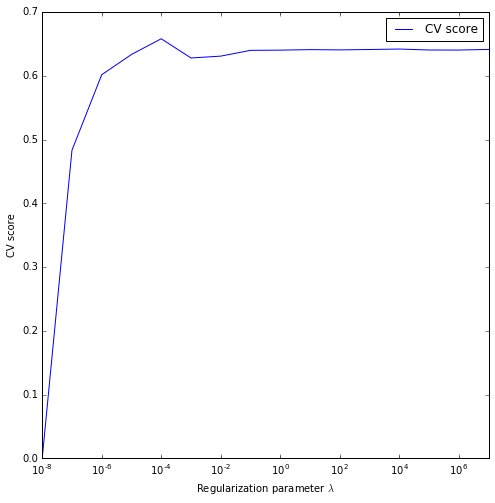

In [170]:
# Parameters for tuning
regularization = 10. ** np.arange(-8, 8)

# To keep track of the best model
best_score = 0

# Run grid search for model with 5-fold cross validation
print '5-fold cross validation:'

class0_train = []

for C in regularization:
    # Cross validation for every experiment
    k_folds = KFold(x_train.shape[0], n_folds=5, shuffle=True)
    tot_scores = []
    class0_score = []
    class1_score = []
    for train_indices, validation_indices in k_folds:
        # Generate training data
        x_train_cv = x_train[train_indices]
        y_train_cv = y_train[train_indices]
        # Generate validation data
        x_validate = x_train[validation_indices]
        y_validate = y_train[validation_indices]
            
        # Fit weighted logit on training data
        wlogit=LogisticRegression(class_weight='balanced',penalty='l1',C=C)
        wlogit.fit(x_train_cv, y_train_cv)
        # Score on validation data
        tot_scores += [wlogit.score(x_validate, y_validate)]
        class0_score += [wlogit.score(x_validate[y_validate==0], y_validate[y_validate==0])]
        class1_score += [wlogit.score(x_validate[y_validate==1], y_validate[y_validate==1])]
        
    # Record and report accuracy
    tot_average_score = np.mean(tot_scores)
    class0_avg = np.mean(class0_score)
    class1_avg = np.mean(class1_score)
    print "C:", C, "Overall Score:", tot_average_score, "Class 0 score:", class0_avg, "Class 1 score:", class1_avg
    
    class0_train.append(class0_avg)
    
    
    # Update our record of the best parameters see so far
    if class0_avg > best_score:
        best_score = class0_avg
        best_C = C
    

print 'Chosen number of C:', best_C
print 'Best accuracy on defaulters:', best_score



fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.semilogx(regularization, (class0_train), c='b', label='CV score')



ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel('CV score')

#ax.set_ylim((test_r_squared_plain-0.2, 1.2))
ax.legend(loc = 'best')

plt.show()

Now that we have our optimum C parameter, we can fit the model and determine the non-zero coefficients, which will be are selected features.

In [24]:
#Feature selection
final_logit=LogisticRegression(class_weight='balanced',penalty='l1',C=best_C)
final_logit.fit(x,y)
coeff=final_logit.coef_

print coeff


[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00  -7.71423764e-04
   -2.57755764e-02   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  -1.05325907e-05  -2.77668530e-03   4.99462550e-03
    0.00000000e+00   0.00000000e+00  -4.74403883e-07   1.45586758e-06
    9.70284414e-06   0.00000000e+00   1.22753214e-03   2.62020561e-02
    0.00000000e+00]]


Below we provide a function that plots a graph to illustrate the lasso coefficients shrinking to zero.

In [230]:
#Lasso & Cross Validation
def lassoreg(x_train, y_train, x_test, y_test, lambda_min, lambda_max, num_lambdas):
   
    num_predictors = x_train.shape[1]

    lambdas= np.linspace(lambda_min,lambda_max, num_lambdas)

    train_r_squared = np.zeros(num_lambdas)
    test_r_squared = np.zeros(num_lambdas)

    coeff_a =np.zeros((num_lambdas, num_predictors))
    
    
    for ind, i in enumerate(lambdas):    
        # Fit ridge/lasso regression on train set
        wlogit=LogisticRegression(class_weight='balanced',penalty='l1',C=10**i)
        wlogit.fit(x_train, y_train)


        coeff_a[ind,:] = wlogit.coef_
    
        ind = ind + 1
        
    return coeff_a, lambdas


#Create functions to plot both coefficients and R^2 as functions of lambda
def PlotCoeff(lambdas, coeff_a):
    plt.figure(figsize=(8,8))
    h=plt.semilogx(10**lambdas, coeff_a);
    plt.ylabel("Standarized Coefficients")
    plt.xlabel(r'Regularization parameter $\lambda$')
    plt.legend(h, train_clean.columns.values,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()



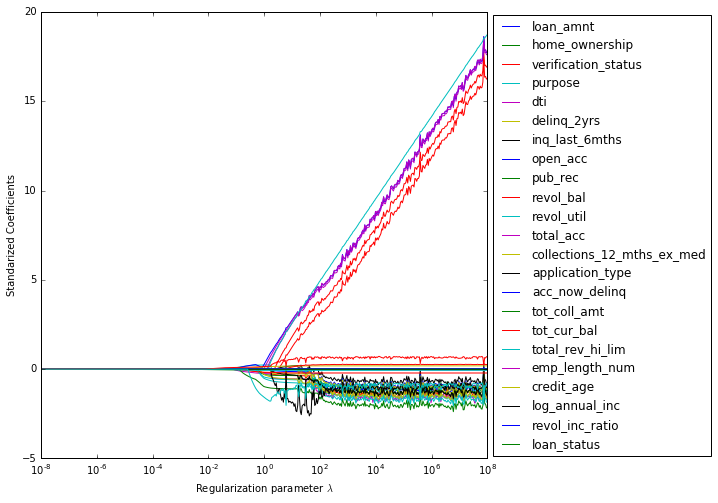

In [231]:
coeff_a, lambdas=lassoreg( x_train, y_train, x_test, y_test, -8, 8, 500)
PlotCoeff(lambdas, coeff_a)

The above model determines an individual's loan status on whether their predicted probability of default was greater or less than 0.5. However, Lending Club may prefer a different threshold (instead of 0.5) to make that decision. Below we plot an ROC curve to illustrate the trade-off between setting these threshold at different rates.

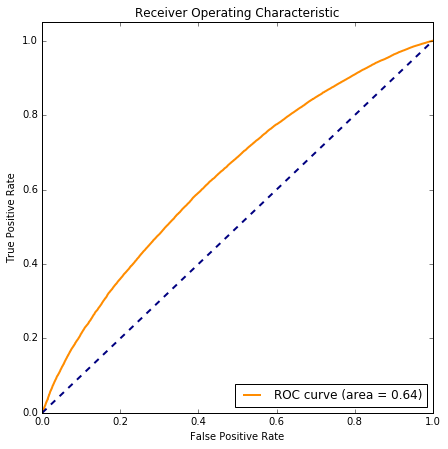

In [25]:
#ROC curve
final_logit=LogisticRegression(class_weight='balanced',penalty='l1',C=best_C)
final_logit.fit(x,y)
y_pred=final_logit.predict_proba(x)


fpr, tpr, thresholds = metrics.roc_curve(y, y_pred[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Finally, we will assess the model's accuracy on the future loan test set that we removed at the very beginning. We first read in the dataset and perform identical cleaning and processing steps.

In [26]:
#Read in test data
loan_test=pd.read_csv('loan_test.csv')
loan_test.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,loan_date
0,65885786,70580529,3600,3600,3600.0,36 months,6.24,109.92,A,A2,...,NaN,NaN,NaN,NaN,NaN,141300.0,NaN,NaN,NaN,2015-12-01
1,67105462,71906185,29000,29000,29000.0,60 months,10.64,625.34,B,B4,...,97.8,0.0,1.0,17930.0,74.1,66500.0,0.0,0.0,0.0,2015-12-01
2,67105380,71906102,6500,6500,6500.0,36 months,8.38,204.83,B,B1,...,71.9,0.0,3.0,4455.0,73.5,8100.0,0.0,0.0,1.0,2015-12-01
3,67135529,71936249,12000,12000,12000.0,36 months,8.38,378.15,B,B1,...,81.1,4.0,5.0,4693.0,80.1,21500.0,1.0,1.0,5.0,2015-12-01
4,67115550,71916273,20000,20000,19850.0,60 months,19.99,529.77,E,E4,...,NaN,4.0,4.0,4957.0,51.2,43800.0,0.0,0.0,5.0,2015-12-01


In [32]:
#Clean loan_data
test_clean=clean_data(loan_test)
getPctMissing(test_clean)

mths_since_last_delinq done
revol_util done
emp_length_num done


loan_amnt                     0.0
home_ownership                0.0
verification_status           0.0
purpose                       0.0
dti                           0.0
delinq_2yrs                   0.0
inq_last_6mths                0.0
mths_since_last_delinq        0.0
open_acc                      0.0
pub_rec                       0.0
revol_bal                     0.0
revol_util                    0.0
total_acc                     0.0
next_pymnt_d                  0.0
collections_12_mths_ex_med    0.0
application_type              0.0
acc_now_delinq                0.0
tot_coll_amt                  0.0
tot_cur_bal                   0.0
total_rev_hi_lim              0.0
emp_length_num                0.0
credit_age                    0.0
log_annual_inc                0.0
revol_inc_ratio               0.0
loan_status                   0.0
dtype: float64

In [37]:
#drop variables that didn't make missing cut
test_final=test_clean[train_clean.columns]
test_final.shape

#Converting credit age to float
to_float = ['credit_age']

# Converted columns to floating point
for feature_name in to_float:
    test_final[feature_name] = test_final[feature_name].astype(float)

/Users/ChristyL/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [39]:
#One hot encoding
(x,y)=one_hot(test_final)

[False  True  True  True False False False False False False False False
 False  True False False False False False False False False  True]
x shape (20530, 38)
y shape (20530,)


In [255]:
#Running final model!
final_logit=LogisticRegression(class_weight='balanced',penalty='l1',C=best_C)
final_logit.fit(x,y)

print 'total accuracy:', final_logit.score(x,y)
print 'accuracy on defaulters:', final_logit.score(x[y==0], y[y==0])
print 'accuracy on fully paid:', final_logit.score(x[y==1], y[y==1])


total accuracy: 0.576668290307
accuracy on defaulters: 0.671269628344
accuracy on fully paid: 0.424080437826
